<a href="https://colab.research.google.com/github/nviraj/era-v1/blob/week-10/Session%2010/Submission/ERA%20V1%20-%20Viraj%20-%20Assignment%2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 10 - Viraj Noorithaya


## Script Parameters


In [1]:
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "colab"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

# git repository url
repo_name = "era-v1"
git_repo_url = "https://github.com/nviraj/era-v1.git"

# Is the model being developed or is it in production?
# Can be development or production
code_mode = "development"

# WHich branch are you working on?
branch_name = "week-10" if code_mode == "development" else "main"
folder_name = "Session 10/Submission"

## Library Installation (Optional)


In [2]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    import sys
    # !{sys.executable} -m pip install torchsummary
    !{sys.executable} -m pip install torch-lr-finder
    !{sys.executable} -m pip install torchinfo

    # if model_run_location == 'colab':
    #     !{sys.executable} -m pip install albumentations

    # # Needed locally
    # !conda install -c conda-forge tqdm
    # !conda install -c anaconda ipywidgets

    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets
        %conda install --yes --prefix {sys.prefix} -c conda-forge imgaug
        %conda install --yes --prefix {sys.prefix} -c conda-forge albumentations


## Code Procurement


In [3]:
# Mount google drive if running on colab
if model_run_location == 'colab':
    # from google.colab import drive
    # drive.mount('/content/drive')
    # %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 10/Submission

    # Delete the folder if it exists
    # Avoids fatal: destination path already exists and is not an empty directory.
    # Get code from github
    !rm -rf {repo_name} && git clone {git_repo_url}

    # Switch to repo folder, Needed to switch branch
    # Switch branch and change to the correct directory
    !cd "{repo_name}" && git checkout {branch_name} && cd "{folder_name}"

Cloning into 'era-v1'...
remote: Enumerating objects: 1135, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 1135 (delta 77), reused 102 (delta 51), pack-reused 984
Receiving objects: 100% (1135/1135), 6.88 MiB | 22.79 MiB/s, done.
Resolving deltas: 100% (570/570), done.
Branch 'week-10' set up to track remote branch 'week-10' from 'origin'.
Switched to a new branch 'week-10'


## Import Libraries


In [4]:
# Import necessary modules (external libs)
import os

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder

# from torchsummary import summary

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
import sys

print(f"CWD: {os.getcwd()}")

if model_run_location == "colab":
    print(f"Appending folder to path in order to detect modules: {folder_name}")
    sys.path.append(f"era-v1/{folder_name}")

CWD: /content
Appending folder to path in order to detect modules: Session 10/Submission


In [6]:
# Import user defined modules
from modules.dataset import split_cifar_data, apply_cifar_image_transformations
from modules.dataset import CIFAR_MEAN, CIFAR_STD, CIFAR_CLASSES
from modules.custom_resnet import CustomResNet as Net
from modules.custom_resnet import detailed_model_summary
from modules.trainer import train_and_test_model
from modules.utils import get_device, save_model, pretty_print_metrics
from modules.visualize import (
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

## Script Parameters


In [7]:
# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Specify the number of epochs
NUM_EPOCHS = 24

# Set the batch size
BATCH_SIZE = 512

# Set seed value for reproducibility
SEED = 8

# Expected accuracy
TARGET_ACCURACY = 90.0

## Get Device


In [8]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()
print(f"Device created with {device_support}!")

Device created with cuda!


### Reproducibility settings


In [10]:
# For reproducibility
# https://pytorch.org/docs/stable/notes/randomness.html
# https://github.com/pytorch/pytorch/issues/7068
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

if device_support == "cuda":
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)


# To be passed to dataloader
def _init_fn(worker_id):
    np.random.seed(int(SEED))

## Data Transformations


In [11]:
# Train and test data transformation steps now moved to apply_mnist_image_transformations()

# cutout needs to be half of the image size
cutout_size = 8

train_transforms, test_transforms = apply_cifar_image_transformations(
    mean=CIFAR_MEAN, std=CIFAR_STD, cutout_size=cutout_size
)

## Train/Test Split


In [12]:
data_path = "../../data"
print(f"Train and test data path: {data_path}")

train_data, test_data = split_cifar_data(data_path, train_transforms, test_transforms)

Train and test data path: ../../data



100%|██████████| 170498071/170498071 [00:01<00:00, 101477193.37it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data
Files already downloaded and verified

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]

Transforms applied on the dataset



## Dataloaders


In [13]:
# calculate the number of workers
num_workers = (os.cpu_count() - 1) if os.cpu_count() > 3 else 2

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=num_workers,
    pin_memory=True,
    worker_init_fn=_init_fn,
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

In [14]:
# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(classes)

('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


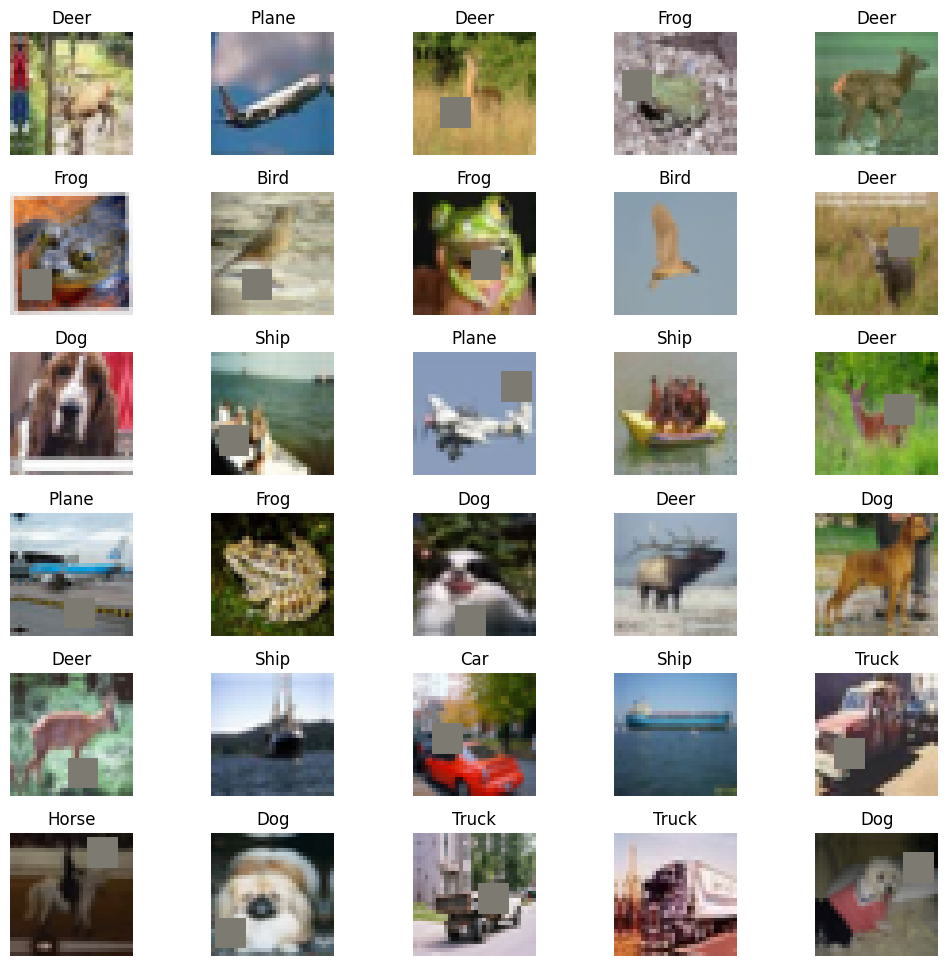

In [15]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(
    batch_data, batch_label, class_label=classes, num_images=30
)
plt.show()

## Model Summary


In [16]:
# Model class is imported from model.py

# Send the model to device
model = Net().to(device)

# enable printing shape
model.print_shape = True

# # Print the model summary by specifying the input size
# summary(model, input_size=(3, 32, 32))
detailed_model_summary(model, input_size=(3, 32, 32), device=device)

# disable printing shape for cleaner test train output
model.print_shape = False

PrepLayer 
 torch.Size([1, 64, 32, 32]) 

Layer 1, X 
 torch.Size([1, 128, 16, 16]) 

Layer 1, R1 
 torch.Size([1, 128, 16, 16]) 

Layer 1, X + R1 
 torch.Size([1, 128, 16, 16]) 

Layer 2 
 torch.Size([1, 256, 8, 8]) 

Layer 3, X 
 torch.Size([1, 512, 4, 4]) 

Layer 3, R2 
 torch.Size([1, 512, 4, 4]) 

Layer 3, X + R2 
 torch.Size([1, 512, 4, 4]) 

Max Pooling 
 torch.Size([1, 512, 1, 1]) 

Reshape before FC 
 torch.Size([1, 512]) 

After FC 
 torch.Size([1, 10]) 

Layer (type:depth-idx)                   Input Shape      Kernel Shape     Output Shape     Param #          Trainable
CustomResNet                             [1, 3, 32, 32]   --               [1, 10]          --               True
├─Sequential: 1-1                        [1, 3, 32, 32]   --               [1, 64, 32, 32]  --               True
│    └─Conv2d: 2-1                       [1, 3, 32, 32]   [3, 3]           [1, 64, 32, 32]  1,728            True
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]  --         

## Train and Test


### Optimizer and Loss Function


In [17]:
# Create optimizer and scheduler
# Use ADAM
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define criteria function
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss()

### Find Learning Rate


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.59E-04


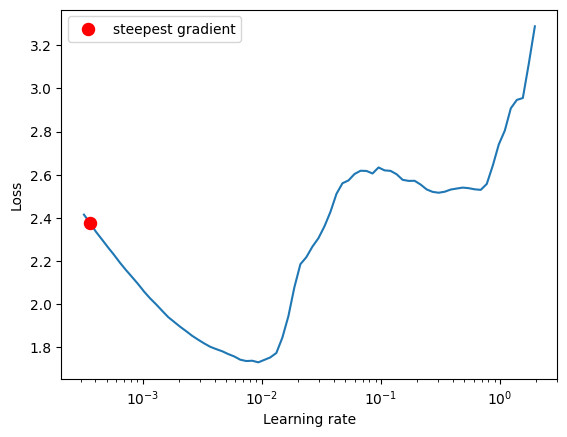

In [18]:
# Use LR Finder to find the best starting learning rate
# https://github.com/davidtvs/pytorch-lr-finder
# https://github.com/davidtvs/pytorch-lr-finder#notes

# Create LR finder object
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader=train_loader, start_lr=1e-4, end_lr=10, num_iter=100)
plot, optimal_lr = lr_finder.plot(suggest_lr=True)
lr_finder.reset()
plot.figure.savefig("LRFinder - Suggested Max LR.png")

### Scheduler


In [19]:
# # Learning rate scheduler based on plateau
# # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
# scheduler = ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.5, patience=1, threshold=0.03, verbose=False
# )

# Learning rate scheduler based on OneCycleLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = OneCycleLR(
    optimizer,
    max_lr=optimal_lr,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=5 / NUM_EPOCHS,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
    verbose=True,
)

Adjusting learning rate of group 0 to 3.5938e-06.


### Train and test model


In [20]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for NUM_EPOCHS
results = train_and_test_model(
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    misclassified_image_data=misclassified_image_data,
)



Batch size: 512, Total epochs: 24


Epoch 1


Train: Loss=1.9060, Batch_id=97, Accuracy=21.48: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]


Test set: Average loss: 0.0038,  Accuracy: 3163/10000  (31.63%)
Adjusting learning rate of group 0 to 4.3214e-06.


Epoch 2


Train: Loss=1.6721, Batch_id=97, Accuracy=35.46: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]


Test set: Average loss: 0.0033,  Accuracy: 4086/10000  (40.86%)
Adjusting learning rate of group 0 to 5.0490e-06.


Epoch 3


Train: Loss=1.5779, Batch_id=97, Accuracy=42.41: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]


Test set: Average loss: 0.0030,  Accuracy: 4608/10000  (46.08%)
Adjusting learning rate of group 0 to 5.7766e-06.


Epoch 4


Train: Loss=1.4499, Batch_id=97, Accuracy=46.88: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]


Test set: Average loss: 0.0028,  Accuracy: 4989/10000  (49.89%)
Adjusting learning rate of group 0 to 6.5041e-06.


Epoch 5


Train: Loss=1.3301, Batch_id=97, Accuracy=50.29: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Test set: Average loss: 0.0026,  Accuracy: 5302/10000  (53.02%)
Adjusting learning rate of group 0 to 7.2317e-06.


Epoch 6


Train: Loss=1.2688, Batch_id=97, Accuracy=53.12: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Test set: Average loss: 0.0025,  Accuracy: 5568/10000  (55.68%)
Adjusting learning rate of group 0 to 7.9593e-06.


Epoch 7


Train: Loss=1.2504, Batch_id=97, Accuracy=55.77: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s]


Test set: Average loss: 0.0024,  Accuracy: 5768/10000  (57.68%)
Adjusting learning rate of group 0 to 8.6869e-06.


Epoch 8


Train: Loss=1.1581, Batch_id=97, Accuracy=57.51: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]


Test set: Average loss: 0.0023,  Accuracy: 5897/10000  (58.97%)
Adjusting learning rate of group 0 to 9.4145e-06.


Epoch 9


Train: Loss=1.1180, Batch_id=97, Accuracy=59.69: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Test set: Average loss: 0.0022,  Accuracy: 6104/10000  (61.04%)
Adjusting learning rate of group 0 to 1.0142e-05.


Epoch 10


Train: Loss=1.0474, Batch_id=97, Accuracy=61.48: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]


Test set: Average loss: 0.0021,  Accuracy: 6260/10000  (62.60%)
Adjusting learning rate of group 0 to 1.0870e-05.


Epoch 11


Train: Loss=1.0426, Batch_id=97, Accuracy=63.37: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]


Test set: Average loss: 0.0020,  Accuracy: 6373/10000  (63.73%)
Adjusting learning rate of group 0 to 1.1597e-05.


Epoch 12


Train: Loss=1.0350, Batch_id=97, Accuracy=65.11: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]


Test set: Average loss: 0.0020,  Accuracy: 6449/10000  (64.49%)
Adjusting learning rate of group 0 to 1.2325e-05.


Epoch 13


Train: Loss=0.9385, Batch_id=97, Accuracy=66.42: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]


Test set: Average loss: 0.0019,  Accuracy: 6631/10000  (66.31%)
Adjusting learning rate of group 0 to 1.3052e-05.


Epoch 14


Train: Loss=0.8397, Batch_id=97, Accuracy=67.77: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]


Test set: Average loss: 0.0019,  Accuracy: 6710/10000  (67.10%)
Adjusting learning rate of group 0 to 1.3780e-05.


Epoch 15


Train: Loss=0.8409, Batch_id=97, Accuracy=68.88: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]


Test set: Average loss: 0.0018,  Accuracy: 6864/10000  (68.64%)
Adjusting learning rate of group 0 to 1.4508e-05.


Epoch 16


Train: Loss=0.8503, Batch_id=97, Accuracy=70.23: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Test set: Average loss: 0.0017,  Accuracy: 6953/10000  (69.53%)
Adjusting learning rate of group 0 to 1.5235e-05.


Epoch 17


Train: Loss=0.8277, Batch_id=97, Accuracy=71.60: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Test set: Average loss: 0.0017,  Accuracy: 7042/10000  (70.42%)
Adjusting learning rate of group 0 to 1.5963e-05.


Epoch 18


Train: Loss=0.8294, Batch_id=97, Accuracy=72.58: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]


Test set: Average loss: 0.0016,  Accuracy: 7172/10000  (71.72%)
Adjusting learning rate of group 0 to 1.6690e-05.


Epoch 19


Train: Loss=0.6267, Batch_id=97, Accuracy=73.48: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Test set: Average loss: 0.0016,  Accuracy: 7178/10000  (71.78%)
Adjusting learning rate of group 0 to 1.7418e-05.


Epoch 20


Train: Loss=0.7376, Batch_id=97, Accuracy=74.62: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Test set: Average loss: 0.0015,  Accuracy: 7294/10000  (72.94%)
Adjusting learning rate of group 0 to 1.8145e-05.


Epoch 21


Train: Loss=0.7296, Batch_id=97, Accuracy=75.59: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]


Test set: Average loss: 0.0015,  Accuracy: 7345/10000  (73.45%)
Adjusting learning rate of group 0 to 1.8873e-05.


Epoch 22


Train: Loss=0.6537, Batch_id=97, Accuracy=76.74: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]


Test set: Average loss: 0.0015,  Accuracy: 7416/10000  (74.16%)
Adjusting learning rate of group 0 to 1.9601e-05.


Epoch 23


Train: Loss=0.6115, Batch_id=97, Accuracy=77.12: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Test set: Average loss: 0.0014,  Accuracy: 7501/10000  (75.01%)
Adjusting learning rate of group 0 to 2.0328e-05.


Epoch 24


Train: Loss=0.6673, Batch_id=97, Accuracy=77.84: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Test set: Average loss: 0.0014,  Accuracy: 7465/10000  (74.65%)
Adjusting learning rate of group 0 to 2.1056e-05.




In [21]:
# Pretty print train and test accuracy and loss values for each epoch
pretty_print_metrics(num_epochs=NUM_EPOCHS, results=results)

Epoch: 01, Train Loss: 2.1915, Test Loss: 0.0038, Train Accuracy: 21.4840, Test Accuracy: 31.6300
Epoch: 02, Train Loss: 1.7986, Test Loss: 0.0033, Train Accuracy: 35.4600, Test Accuracy: 40.8600
Epoch: 03, Train Loss: 1.6162, Test Loss: 0.0030, Train Accuracy: 42.4120, Test Accuracy: 46.0800
Epoch: 04, Train Loss: 1.4882, Test Loss: 0.0028, Train Accuracy: 46.8780, Test Accuracy: 49.8900
Epoch: 05, Train Loss: 1.3985, Test Loss: 0.0026, Train Accuracy: 50.2860, Test Accuracy: 53.0200
Epoch: 06, Train Loss: 1.3212, Test Loss: 0.0025, Train Accuracy: 53.1160, Test Accuracy: 55.6800
Epoch: 07, Train Loss: 1.2522, Test Loss: 0.0024, Train Accuracy: 55.7720, Test Accuracy: 57.6800
Epoch: 08, Train Loss: 1.1963, Test Loss: 0.0023, Train Accuracy: 57.5080, Test Accuracy: 58.9700
Epoch: 09, Train Loss: 1.1409, Test Loss: 0.0022, Train Accuracy: 59.6920, Test Accuracy: 61.0400
Epoch: 10, Train Loss: 1.0894, Test Loss: 0.0021, Train Accuracy: 61.4760, Test Accuracy: 62.6000
Epoch: 11, Train Los

## Metrics


Expected accuracy: 90.0%
Plotting accuracy and loss graphs.


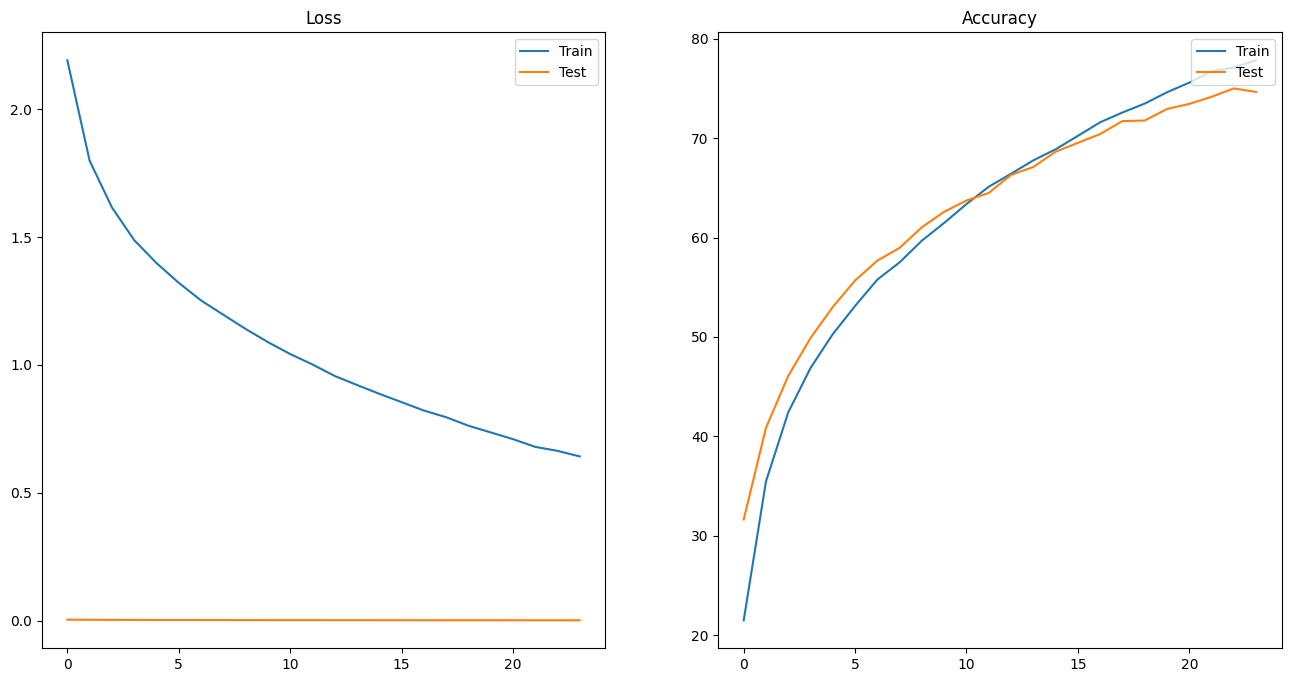

<Figure size 640x480 with 0 Axes>

In [22]:
# Print expected accuracy for easier reference
print(f"Expected accuracy: {TARGET_ACCURACY}%")

# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()
plt.savefig("Loss and Accuracy Metrics.png")

## Save model


In [23]:
# Save model
print("Saving the model as the training is complete!")
save_model(
    epoch=NUM_EPOCHS,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=BATCH_SIZE,
    criterion=criterion,
    file_name="model_last_epoch.pth",
)

Saving the model as the training is complete!


## Show incorrect images


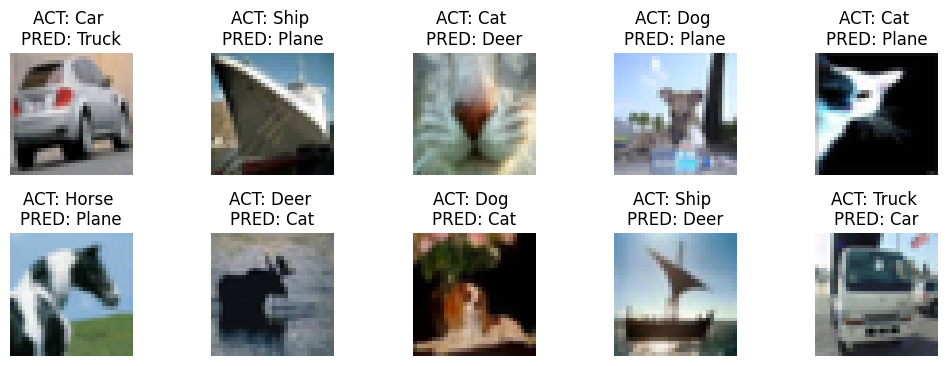

<Figure size 640x480 with 0 Axes>

In [24]:
# Plot misclassified images
fig, axs = plot_misclassified_images(
    data=misclassified_image_data, class_label=classes, num_images=10
)
plt.show()
plt.savefig("Misclassified Images.png")